# Emcee Testing

## Simple Lorentzian No Background

In [83]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

#sig_dist = sp.stats.halfcauchy
#signal = sig_dist.rvs(scale=kappa, loc=0.0, size=nsig)

bg = np.random.uniform(xrange[0], xrange[1], nbg)

events = curv.data
#events = np.concatenate((curv.data, bg))


[0.0001]
Generated 10000 samples using parameters [0.01111111]


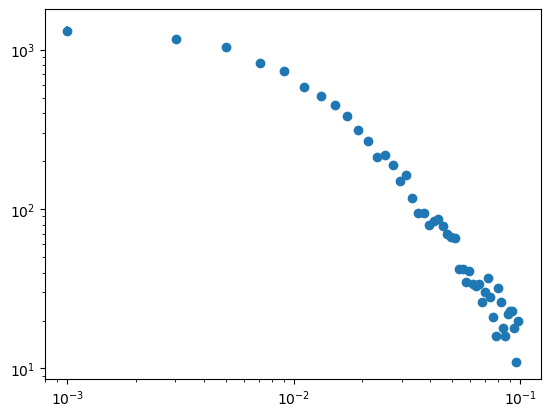

In [84]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [98]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim:
        return 0.0
    
    return -np.inf

def pmf(xvals, theta):
    
    kappa = np.asarray(theta)
    
    result = curv.curve(kappa, dat=xvals)    
    return result


def log_likelihood(theta):
    kappa = np.asarray(theta)
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    ll = curv.llcurve(kappa)
    
    result = lp + ll
    
    if np.isnan(result):
        print("NaN result for theta, prior", theta, lp)
    
    return result


p0 = np.array([0.02])


print(log_likelihood(p0))

21867.733747403174


In [99]:
ndim, nwalkers = 1, 32

p0 = np.array(0.02)

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

100%|████████████████████████████████████████| 500/500 [00:00<00:00, 503.01it/s]


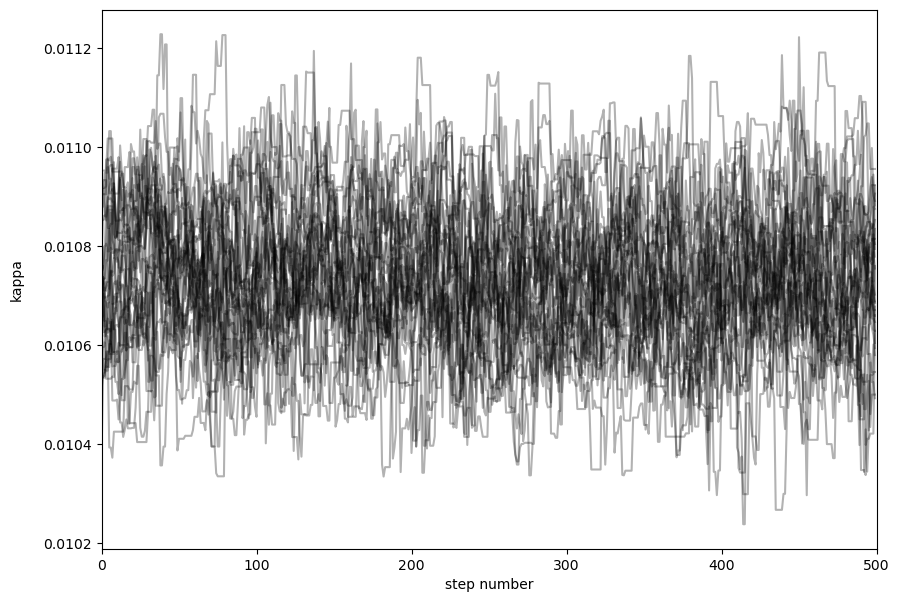

In [100]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa"]
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel(labels[0])
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xlabel("step number");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Q (Å-1)')

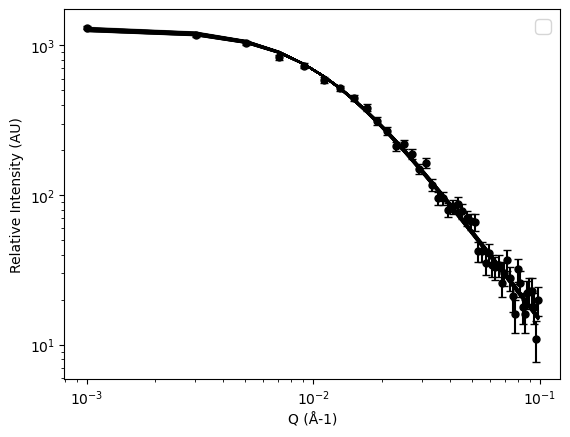

In [101]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')

## Lorentzian With Background

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import emcee

import emtk.curves.lorentzian as lor


nsig = 10000
nbg = 10000

ratio = float(nsig) / float(nbg)
nbins = 50

xrange = np.array([0.001, 0.1])

clength = 90.0 # correlation length in system
kappa = 1.0 / clength
curv = lor.LorentzianCurve()
pvalues = np.array([kappa])
xrange = np.array([0.001, 0.1])

curv.generate_test_samples(pvalues, xrange, nsig)

curv.generate_background(xrange, ratio = ratio)


events = curv.data

Loading ESS event mode toolkit (emtk)
Loading curves
Loading omega functions
[0.0001]
Generated 10000 samples using parameters [0.01111111]
Adding flat background of 10000.0 points


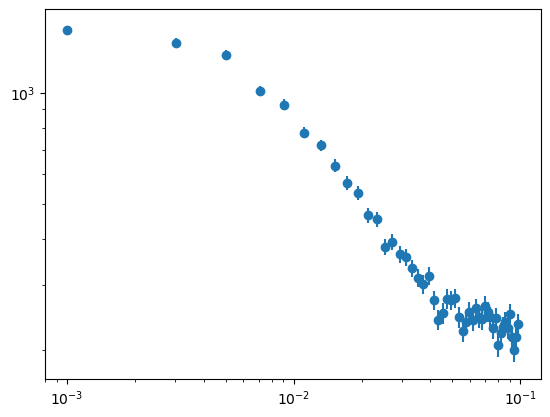

In [2]:
qmin = np.amin(events)
qmax = np.amax(events)
bins = np.linspace(qmin, qmax, nbins)
hst = np.histogram(events, bins=bins)
xvals = hst[1]
xvals = xvals[:-1]
yvals = hst[0]
evals = np.sqrt(yvals)

plt.errorbar(xvals, yvals, yerr=evals, ls='None', marker='o')
plt.yscale('log')
plt.xscale('log')

In [30]:
def log_prior(theta):
    # The main role of this function is to set 
    # parameter bounds of the bayesian search space
    kappa, Q = theta
    
    lolim = 0.001
    hilim = 0.1
    
    if lolim < kappa < hilim:
        return 0.0
    
    return -np.inf

def pmf(xvals, theta):
    
    kappa, Q = theta
    
    result = curv.curve(np.array([kappa]), dat=xvals)    
    return result


def log_likelihood(theta):
    kappa, Q = theta
    
    
    lp = log_prior(theta)
    
    if np.isinf(lp):
        return -np.inf
    
    ll = curv.llcurve(np.array([kappa]))
    if np.isnan(ll):
        print("NaN result for theta, prior", theta, lp)

    arg1 = ll + np.log(Q)
    
    # bg in this case is just a flat constant
    lbg = np.log(1.0-Q)
    
    result = lp + ll#, arg1, lbg
    

    
    return result


p0 = np.array([0.02, 0.5])


print(log_likelihood(p0))

31046.57223038917


In [27]:
ndim, nwalkers = 2, 32

p0 = np.array([0.02, 0.5])

p0 = [p0 + 1e-5 * np.random.randn(ndim) for k in range(nwalkers)]

# Set up the sampler.
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)

# Run a burn-in chain and save the final location.
state = sampler.run_mcmc(p0, 100)

# Run the production chain.
sampler.reset()
sampler.run_mcmc(state, 500, progress=True);

/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2138/1710913769.py:40: RuntimeWarning: invalid value encountered in log
  lbg = np.log(1.0-Q)
/var/folders/th/9shc9qg10f7brtgj6hbfmnpw0000gn/T/ipykernel_2138/1710913769.py:37: RuntimeWarning: invalid value encountered in log
  arg1 = ll + np.log(Q)
100%|████████████████████████████████████████| 500/500 [00:01<00:00, 256.15it/s]


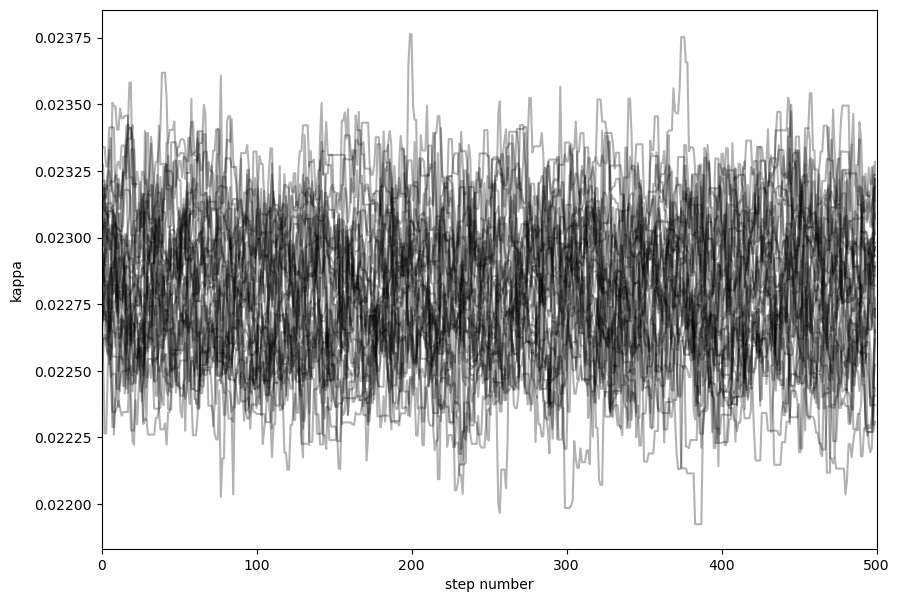

In [28]:
fig, ax = plt.subplots(1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["kappa"]
ax.plot(samples[:, :, 0], "k", alpha=0.3)
ax.set_xlim(0, len(samples))
ax.set_ylabel(labels[0])
ax.yaxis.set_label_coords(-0.1, 0.5)

ax.set_xlabel("step number");

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Q (Å-1)')

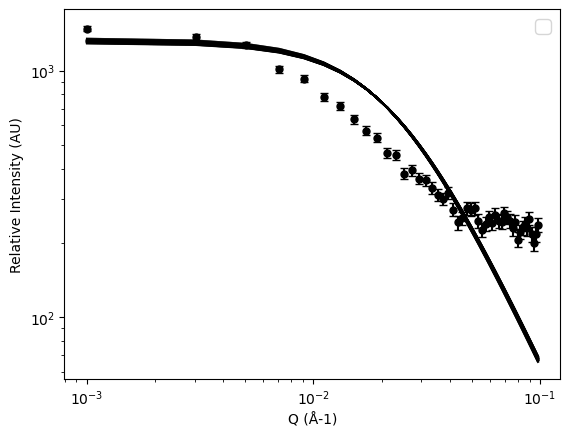

In [31]:
inds = np.random.randint(len(flat_samples), size=100)

pt_sum = np.sum(yvals)

fig, ax = plt.subplots()
for ind in inds:
    sample = flat_samples[ind]
    yplot = pmf(xvals, sample)
    ysum = np.sum(yplot)
    scale = pt_sum / ysum
    yplot = yplot * scale
    plt.plot(xvals, yplot, color='black', alpha = 0.4 )# np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)

plt.errorbar(xvals, yvals, yerr=np.sqrt(yvals), fmt=".k", markersize=10, capsize=3)
#plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.ylabel("Relative Intensity (AU)")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Q (Å-1)')